# Traitement dataset pollution

[![Pollution](https://www.pranaair.com/wp-content/uploads/2018/08/impacts-of-air-pollution.jpg)](https://www.data.gouv.fr/fr/datasets/qualite-de-lair-mesuree-dans-la-station-chatelet/)

### Installation et import bibliothèque

In [6]:
!pip install statsmodels


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error
from math import sqrt

In [76]:
df_pollution = pd.read_csv('pollution.csv', sep=';')
df_pollution

,dateheure,nocha4,n2cha4,10cha4,c2cha4,tcha4,hycha4
0,2024-03-24T23:00:00+00:00,ND,26,23,503,"18,3",38
1,2024-03-24T22:00:00+00:00,<2,33,23,518,"18,4","37,2"
2,2024-03-24T21:00:00+00:00,<2,31,23,524,"18,6","36,6"
3,2024-03-24T20:00:00+00:00,ND,20,28,536,"18,6","36,2"
4,2024-03-24T19:00:00+00:00,ND,18,42,567,"18,2","35,7"
...,...,...,...,...,...,...,...
98194,2013-01-01T04:00:00+00:00,4,26,102,622,"21,2","45,9"
98195,2013-01-01T03:00:00+00:00,3,25,85,715,"21,6","45,8"
98196,2013-01-01T02:00:00+00:00,4,27,124,799,"21,8",47
98197,2013-01-01T01:00:00+00:00,6,30,166,800,"21,6","47,3"


In [77]:
df_pollution = df_pollution.rename(columns={"dateheure": "Date", "nocha4": "NO", "n2cha4": "NO2", "10cha4": "PM10", "c2cha4": "CO2", "tcha4": "Temp", "hycha4": "Humidite"}, errors="raise")
df_pollution['NO'] = df_pollution['NO'].str.replace('ND', '0')
df_pollution['NO'] = df_pollution['NO'].str.replace('<', '')
df_pollution.dropna(subset=['NO'], inplace=True)
df_pollution.dropna(subset=['NO2'], inplace=True)
df_pollution.dropna(subset=['PM10'], inplace=True)
df_pollution.dropna(subset=['CO2'], inplace=True)
df_pollution.dropna(subset=['Humidite'], inplace=True)
df_pollution

,Date,NO,NO2,PM10,CO2,Temp,Humidite
0,2024-03-24T23:00:00+00:00,0,26,23,503,"18,3",38
1,2024-03-24T22:00:00+00:00,2,33,23,518,"18,4","37,2"
2,2024-03-24T21:00:00+00:00,2,31,23,524,"18,6","36,6"
3,2024-03-24T20:00:00+00:00,0,20,28,536,"18,6","36,2"
4,2024-03-24T19:00:00+00:00,0,18,42,567,"18,2","35,7"
...,...,...,...,...,...,...,...
98194,2013-01-01T04:00:00+00:00,4,26,102,622,"21,2","45,9"
98195,2013-01-01T03:00:00+00:00,3,25,85,715,"21,6","45,8"
98196,2013-01-01T02:00:00+00:00,4,27,124,799,"21,8",47
98197,2013-01-01T01:00:00+00:00,6,30,166,800,"21,6","47,3"


In [78]:
df_pollution['Date'] = pd.to_datetime(df_pollution['Date'])
df_pollution = df_pollution.set_index('Date').sort_index()
df_pollution = df_pollution.resample('D').mean()
df_pollution.head()

C:\Users\antho\AppData\Local\Temp\ipykernel_4808\1657217801.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pollution = df_pollution.resample('D').mean()


,NO
Date,
2013-01-01 00:00:00+00:00,2.768099e+36
2013-01-02 00:00:00+00:00,2.217717e+43
2013-01-03 00:00:00+00:00,1.342672e+40
2013-01-04 00:00:00+00:00,1.053631e+36
2013-01-05 00:00:00+00:00,4.020307e+29


0

,nocha4,NO,NO2,CO2,Temp,Humidite
Date,,,,,,
2024-03-24 23:00:00+00:00,ND,26,23,503,"18,3",38
2024-03-24 22:00:00+00:00,<2,33,23,518,"18,4","37,2"
2024-03-24 21:00:00+00:00,<2,31,23,524,"18,6","36,6"
2024-03-24 20:00:00+00:00,ND,20,28,536,"18,6","36,2"
2024-03-24 19:00:00+00:00,ND,18,42,567,"18,2","35,7"
...,...,...,...,...,...,...
2013-01-01 04:00:00+00:00,4,26,102,622,"21,2","45,9"
2013-01-01 03:00:00+00:00,3,25,85,715,"21,6","45,8"
2013-01-01 02:00:00+00:00,4,27,124,799,"21,8",47


ConversionError: Failed to convert value(s) to axis units: 'ND'

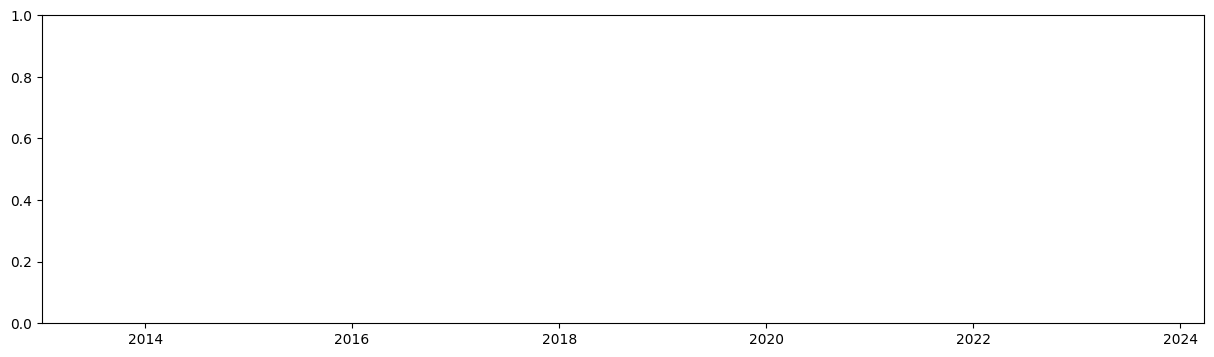

In [51]:
plt.figure(figsize=(15,4))
plt.axis([df_pollution.index.min(), df_pollution.index.max(), 0, df_pollution['CO2'].max()])
#plt.plot(df_pollution['CO2'])
plt.gca().set(title='Evolution du CO2', xlabel='Date', ylabel='Nombre de passagers')
plt.xticks(rotation=90)
plt.show()